In [27]:
import numpy as np # linear algebra
import pandas as pd

In [29]:
#Checking GPU
import torch
print(torch.cuda.get_device_name(0))


Tesla T4


In [30]:
#Searching the path of the dataset uploaded
import os
if os.path.exists('/kaggle/input'):
    print("Datasets in /kaggle/input:", os.listdir('/kaggle/input'))
else:
    print("/kaggle/input does not exist in this environment.")



Datasets in /kaggle/input: ['tcd-dataset']


In [31]:
import os
print(os.listdir('/kaggle/input/tcd-dataset'))


['meta', 'images', 'masks']


In [32]:
#/images/dataset/holdout/images


# Define the correct paths based on your structure
image_dir = '/kaggle/input/tcd-dataset/images/dataset/holdout/images'
mask_dir ='/kaggle/input/tcd-dataset/masks/dataset/holdout/masks'
meta_dir = '/kaggle/input/tcd-dataset/meta'


print("Sample images:", os.listdir(image_dir)[:5])
print("Sample masks:", os.listdir(mask_dir)[:5])
print("Metadata files:", os.listdir(meta_dir))


Sample images: ['60a6469525820c0005e45927_4050.tif', '5f0dbb76f70d2a0006c1e8f0_3265.tif', '5d970af00a75b7000670395f_3693.tif', '5b729f5e9102ad0b033a5c3f_2249.tif', '5e24f9cf2554740005d5c9bb_2970.tif']
Sample masks: ['5a70b6785a9ef7cb5d2bf31e_1487.png', '6108b0df343da30006976e23_2832.png', '5c3cb31865775c0007e79448_3369.png', '59e62b963d6412ef7220a3c9_1298.png', '5a808bed5a9ef7cb5d552d69_506.png']
Metadata files: ['train_meta.json', 'test_meta.json']


In [33]:
#OFFICIALY SPLITTING TEST AND TRAIN BASED ON METADATA
import json
with open(os.path.join(meta_dir, 'test_meta.json'), 'r') as f:
    test_meta = [json.loads(line) for line in f]

with open(os.path.join(meta_dir, 'train_meta.json'), 'r') as f:
    train_meta = [json.loads(line) for line in f]


In [34]:
# For test set
test_image_names = {
    f"{item['oam_id']}_{item['image_id']}.tif" for item in test_meta
}
# For train/val set
trainval_image_names = {
    f"{item['oam_id']}_{item['image_id']}.tif" for item in train_meta
}


In [35]:
test_mask_names = {
    f"{item['oam_id']}_{item['image_id']}.png" for item in test_meta
}
trainval_mask_names = {
    f"{item['oam_id']}_{item['image_id']}.png" for item in train_meta
}

In [36]:
# List all files in the folders
image_files = set(os.listdir(image_dir))
mask_files = set(os.listdir(mask_dir))

# Keep only those that exist in both the directory and the metadata
test_image_files = sorted(list(test_image_names & image_files))
test_mask_files = sorted(list(test_mask_names & mask_files))

trainval_image_files = sorted(list(trainval_image_names & image_files))
trainval_mask_files = sorted(list(trainval_mask_names & mask_files))

print("Test images:", test_image_files[:3])
print("Test masks:", test_mask_files[:3])
print("Train/val images:", trainval_image_files[:3])
print("Train/val masks:", trainval_mask_files[:3])


Test images: ['59e62b793d6412ef722094d2_1592.tif', '59e62b793d6412ef722094d2_1607.tif', '59e62b793d6412ef722094d2_2105.tif']
Test masks: ['59e62b793d6412ef722094d2_1592.png', '59e62b793d6412ef722094d2_1607.png', '59e62b793d6412ef722094d2_2105.png']
Train/val images: ['59e62b703d6412ef72208f44_1564.tif', '59e62b703d6412ef72208f44_1919.tif', '59e62b703d6412ef72208f44_2450.tif']
Train/val masks: ['59e62b703d6412ef72208f44_1564.png', '59e62b703d6412ef72208f44_1919.png', '59e62b703d6412ef72208f44_2450.png']


In [37]:
from sklearn.model_selection import train_test_split

# Use the official trainval_image_files and trainval_mask_files from previous step
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    trainval_image_files, trainval_mask_files, test_size=0.2, random_state=42
)


In [11]:
problematic_path = '/kaggle/input/tcd-dataset/images/dataset/holdout/images/5da4eb2dcac1190007698b1b_4607.tif'
print(f"File exists: {os.path.exists(problematic_path)}")  # Likely False - path typo


File exists: True


In [38]:
from torch.utils.data import Dataset
from PIL import Image, ImageFile, UnidentifiedImageError
import torch
import numpy as np
import os

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class TCDDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, mask_files, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.mask_files = mask_files
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            # Load image and mask with error handling
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
            
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert('L')  # Force grayscale

            # Convert to numpy arrays
            image = np.array(image)
            mask = np.array(mask)

            # Ensure mask is binary (0 or 1)
            mask = (mask > 0).astype(np.uint8)

            # Convert to tensors
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).long()

            # Normalize image
            if image.max() > 255:  # 16-bit
                image /= 65535.0
            else:  # 8-bit
                image /= 255.0

            # Validate tensors
            assert not torch.isnan(image).any(), f"NaN in image {self.image_files[idx]}"
            assert not torch.isinf(image).any(), f"Inf in image {self.image_files[idx]}"
            assert torch.all(torch.logical_or(mask == 0, mask == 1)), \
                f"Invalid mask values in {self.mask_files[idx]}"

            # Apply transforms
            if self.transforms:
                image, mask = self.transforms(image, mask)

            # Prepare target
            target = self._prepare_target(mask)
            return image, target

        except (UnidentifiedImageError, OSError, TypeError, ValueError) as e:
            print(f"Skipping corrupted file pair: {img_path} | Error: {str(e)[:100]}")
            return None


    def _prepare_target(self, mask):
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]  # Remove background

        if len(obj_ids) == 0:
            return {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "masks": torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
            }

        # Create binary masks for each instance
        masks = (mask == obj_ids[:, None, None]).to(torch.uint8)
        
        # Calculate valid bounding boxes
        boxes = []
        for i in range(len(obj_ids)):
            pos = torch.where(masks[i])
            if len(pos[0]) == 0:  # Skip empty masks
                continue
                
            xmin = torch.min(pos[1])
            xmax = torch.max(pos[1])
            ymin = torch.min(pos[0])
            ymax = torch.max(pos[0])
            
            if xmin < xmax and ymin < ymax:  # Check valid box dimensions
                boxes.append([xmin, ymin, xmax, ymax])

        # Handle case with no valid boxes
        if not boxes:
            return {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "masks": torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
            }

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        return {
            "boxes": boxes,
            "labels": labels,
            "masks": masks[:len(boxes)]  # Align masks with valid boxes
        }


In [39]:
train_dataset = TCDDataset(image_dir, mask_dir, train_imgs, train_masks)
val_dataset = TCDDataset(image_dir, mask_dir, val_imgs, val_masks)
test_dataset = TCDDataset(image_dir, mask_dir, test_image_files, test_mask_files)


In [40]:
from torch.utils.data import default_collate

def collate_fn(batch):
    # Filter out None values (corrupted samples)
    batch = [b for b in batch if b is not None]
    
    if len(batch) == 0:
        return [], []  # Return empty batch if all samples are corrupted
    
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets



In [41]:
from torch.utils.data import DataLoader

batch_size_train_val = 2 # You can adjust based on GPU memory
batch_size_test = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size_train_val,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size_train_val,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=False,
    collate_fn=collate_fn
)


In [42]:
images, targets = next(iter(train_loader))
print(type(images), type(targets))           # Should both be <class 'list'>
print(type(targets[0]), targets[0].keys())   # Should be <class 'dict'>, dict_keys(['boxes', 'labels', 'masks'])


<class 'list'> <class 'list'>
<class 'dict'> dict_keys(['boxes', 'labels', 'masks'])


In [43]:
#Forward pass to test if everything is ready
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

# 1. Initialize Mask R-CNN model
num_classes = 2  # Background (0) + Tree (1)
model = maskrcnn_resnet50_fpn(weights=None, num_classes=num_classes)

# 2. Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3. Test forward pass
model.eval()
images, targets = next(iter(train_loader))

# Move data to device
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# Forward pass
with torch.no_grad():
    output = model(images, targets)

print("Forward pass successful! 🚀")
print("Output keys:", output[0].keys())  # Should show ['loss_classifier', ...]


Forward pass successful! 🚀
Output keys: dict_keys(['boxes', 'labels', 'scores', 'masks'])


In [44]:
model.train()  # Set model to training mode
images, targets = next(iter(train_loader))

# Move to GPU
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# Forward pass (computes losses)
loss_dict = model(images, targets)
print("Training loss keys:", loss_dict.keys())


Training loss keys: dict_keys(['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'])


In [48]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.amp import autocast
import os
import shutil

# --- 0. Make sure output dir exists ---
output_dir = "/kaggle/working/model_output"
os.makedirs(output_dir, exist_ok=True)

# 1. Model setup with frozen backbone
num_classes = 2
model = maskrcnn_resnet50_fpn(weights=None, num_classes=num_classes)

# Freeze backbone layers except final block
for name, param in model.backbone.named_parameters():
    if 'layer4' not in name:
        param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 2. Optimizer and scheduler
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 3. Mixed precision setup
scaler = torch.cuda.amp.GradScaler()

# 4. Checkpoint handling (for resume)
start_epoch = 0
latest_ckpt = os.path.join(output_dir, "latest.pth")
if os.path.exists(latest_ckpt):
    checkpoint = torch.load(latest_ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    lr_scheduler.last_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")

# 5. Training loop with per-epoch saves
num_epochs = 5
for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        torch.cuda.empty_cache()
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast(device_type='cuda'):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()
        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx} | Loss: {losses.item():.4f}")
    
    lr_scheduler.step()
    
    # validation...
    model.train()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            with autocast(device_type='cuda'):
                ld = model(images, targets)
                val_loss += sum(v for v in ld.values()).item()
                del images, targets
                torch.cuda.empty_cache()
    
    model.eval()
                
    print(f"Epoch [{epoch+1}/{num_epochs}] Train: {epoch_loss/len(train_loader):.4f} | Val: {val_loss/len(val_loader):.4f}")

    
    # --- SAVE CHECKPOINTS HERE ---
    # 1) epoch-specific
    epoch_path = os.path.join(output_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        'train_loss': epoch_loss/len(train_loader),
        'val_loss': val_loss/len(val_loader),
    }, epoch_path)
    # 2) overwrite “latest” for resume
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    }, latest_ckpt)
    print(f"Saved weights to:\n • {epoch_path}\n • {latest_ckpt}")

# --- BONUS: ZIP THEM ALL FOR EASY DOWNLOAD ---
shutil.make_archive(
    base_name="/kaggle/working/model_output_archive",
    format="zip",
    root_dir=output_dir
)
print("All model files zipped at /kaggle/working/model_output_archive.zip")

print("Training complete!")

/tmp/ipykernel_35/3538726657.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1 | Batch 0 | Loss: 2.3660
Epoch 1 | Batch 20 | Loss: 1.3645
Epoch 1 | Batch 40 | Loss: 1.1764
Epoch 1 | Batch 60 | Loss: 0.7866
Epoch 1 | Batch 80 | Loss: 1.0520
Epoch 1 | Batch 100 | Loss: 0.4040
Epoch 1 | Batch 120 | Loss: 0.6761
Epoch 1 | Batch 140 | Loss: 0.5876
Epoch 1 | Batch 160 | Loss: 0.3821
Epoch 1 | Batch 180 | Loss: 0.3025
Epoch 1 | Batch 200 | Loss: 0.6747
Epoch 1 | Batch 220 | Loss: 0.5002
Epoch 1 | Batch 240 | Loss: 0.4337
Epoch 1 | Batch 260 | Loss: 0.4223
Epoch 1 | Batch 280 | Loss: 0.5228
Epoch 1 | Batch 300 | Loss: 0.6040
Epoch 1 | Batch 320 | Loss: 0.6106
Epoch 1 | Batch 340 | Loss: 0.6204
Epoch 1 | Batch 360 | Loss: 0.5354
Epoch 1 | Batch 380 | Loss: 0.5116
Epoch 1 | Batch 400 | Loss: 0.8275
Epoch 1 | Batch 420 | Loss: 0.4265
Epoch 1 | Batch 440 | Loss: 0.3484
Epoch 1 | Batch 460 | Loss: 0.4357
Epoch 1 | Batch 480 | Loss: 0.5449
Epoch 1 | Batch 500 | Loss: 0.4856
Epoch 1 | Batch 520 | Loss: 0.5272
Epoch 1 | Batch 540 | Loss: 0.5577
Epoch 1 | Batch 560 | Loss

In [49]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import torchvision.transforms as T

# 1. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Rebuild model architecture
num_classes = 2  # same as in training
model = maskrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
model.to(device)

# 3. Load checkpoint
ckpt_path = "/kaggle/working/model_output/latest.pth"  # or model_epoch_10.pth
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded checkpoint from epoch {checkpoint['epoch']+1}")
all_outputs = []
with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)  # list of dicts: boxes, labels, scores, masks
        # bring outputs back to CPU for processing
        cpu_outputs = [{k: v.cpu() for k, v in out.items()} for out in outputs]
        all_outputs.extend(cpu_outputs)

# 6. (Optional) Quick sanity-print of first result
print(all_outputs[0])
# e.g. {'boxes': Tensor(...), 'labels': Tensor(...), 'scores': Tensor(...), 'masks': Tensor(...)}

# 7. (Optional) Save outputs to disk for later metric computation
import json
from pathlib import Path

out_path = Path("/kaggle/working/model_output/test_predictions.json")
serializable = []
for out in all_outputs:
    # convert tensors to lists
    serializable.append({
        "boxes": out["boxes"].tolist(),
        "labels": out["labels"].tolist(),
        "scores": out["scores"].tolist(),
        # masks can be huge—omit or encode sparsely if needed
    })

with open(out_path, "w") as f:
    json.dump(serializable, f)

print(f"Saved {len(all_outputs)} predictions to {out_path}")

Loaded checkpoint from epoch 5
{'boxes': tensor([[   0.0000,    0.0000, 2048.0000, 2027.7081]]), 'labels': tensor([1]), 'scores': tensor([0.8829]), 'masks': tensor([[[[0.1061, 0.1090, 0.1118,  ..., 0.0850, 0.0829, 0.0808],
          [0.1090, 0.1120, 0.1149,  ..., 0.0874, 0.0852, 0.0830],
          [0.1119, 0.1150, 0.1180,  ..., 0.0897, 0.0875, 0.0852],
          ...,
          [0.1105, 0.1135, 0.1165,  ..., 0.0525, 0.0511, 0.0498],
          [0.1048, 0.1077, 0.1105,  ..., 0.0497, 0.0485, 0.0473],
          [0.0991, 0.1018, 0.1044,  ..., 0.0470, 0.0458, 0.0447]]]])}
Saved 439 predictions to /kaggle/working/model_output/test_predictions.json


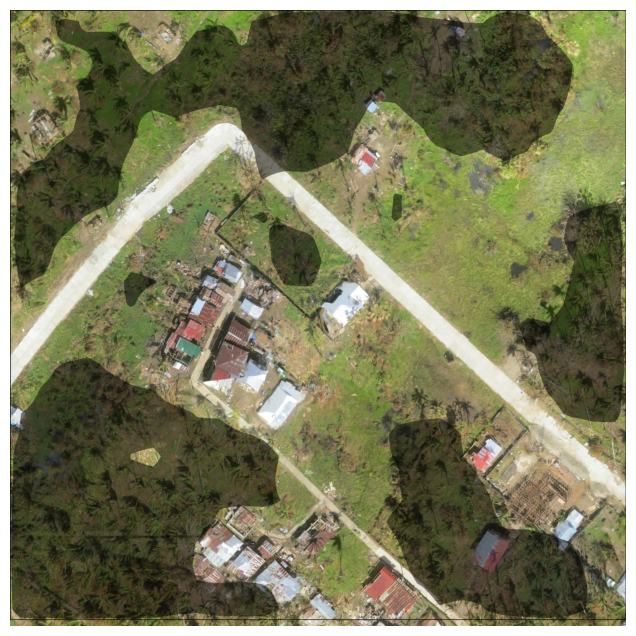

In [56]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# 1. Grab one batch from your test_loader
images, _ = next(iter(test_loader))
image = images[0].to(device)           # pick the first image in the batch

# 2. Run inference
model.eval()
with torch.no_grad():
    output = model([image])[0]

# 3. Filter out low-confidence detections
score_thresh = 0.5
keep = output['scores'] > score_thresh
boxes  = output['boxes'][keep].cpu()
masks  = output['masks'][keep][:, 0].cpu() > 0.5   # turn into boolean H×W
labels = output['labels'][keep].cpu()

# 4. Draw masks (semi-transparent) then boxes
#    Note: draw_... works on a CPU tensor image in [0,1] or [0,255] range.
#    Our image is in [0,1], so no rescaling needed.
img_cpu = image.cpu()
masks_overlay = draw_segmentation_masks(img_cpu, masks, alpha=0.5)
boxed = draw_bounding_boxes(
    masks_overlay, 
    boxes, 
    width=2
)

# 5. Display
plt.figure(figsize=(8,8))
plt.imshow(boxed.permute(1,2,0))   # C×H×W → H×W×C
plt.axis('off')
plt.show()


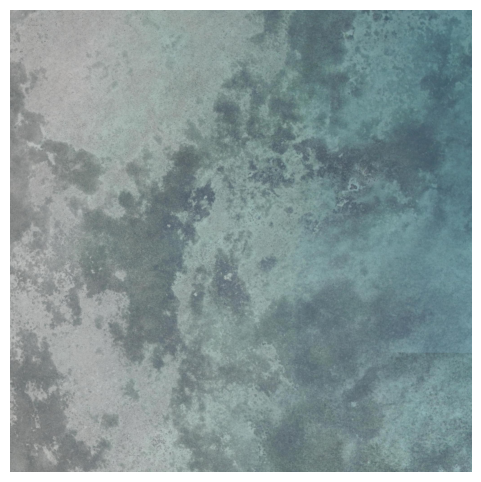

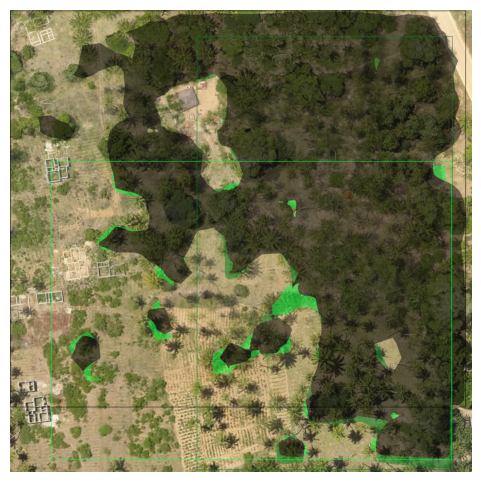

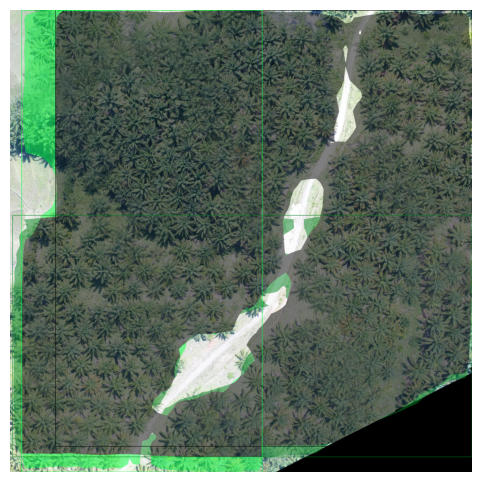

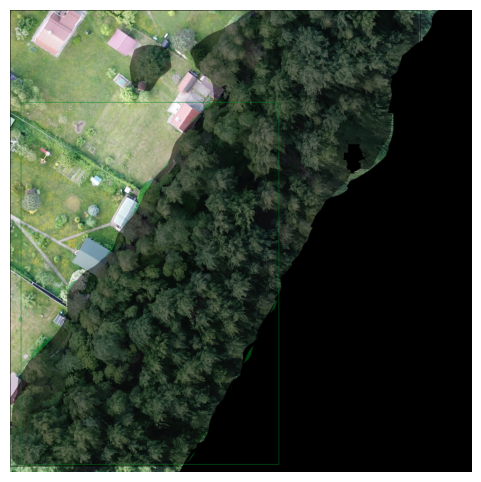

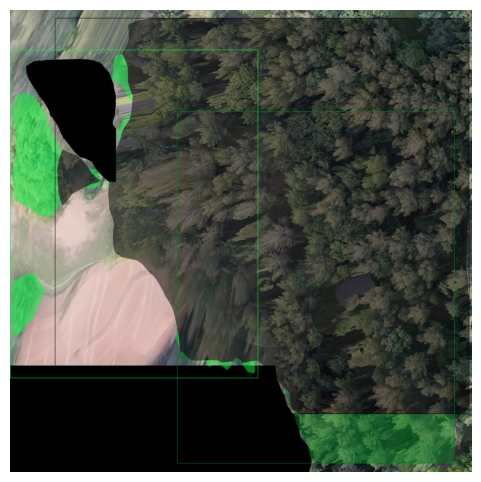

In [58]:
import random
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# 1. Get the underlying dataset
dataset = test_loader.dataset  # assumes you created test_loader from your CustomDataset

# 2. Sample 5 random indices
num_samples = len(dataset)
random_idxs = random.sample(range(num_samples), 5)

# 3. Fetch those (image, target) pairs
samples = [dataset[i] for i in random_idxs]
images, _ = zip(*samples)         # we only need the images

# 4. Move them to device
images = [img.to(device) for img in images]

# 5. Run inference
model.eval()
with torch.no_grad():
    outputs = model(images)       # list of dicts

# 6. (Optional) Visualize each
score_thresh = 0.5
for img_tensor, out in zip(images, outputs):
    # filter by score
    keep = out["scores"] > score_thresh
    boxes = out["boxes"][keep].cpu()
    masks = (out["masks"][keep][:, 0].cpu() > 0.5)
    
    # draw overlays
    base = img_tensor.cpu()
    masked = draw_segmentation_masks(base, masks, alpha=0.5)
    boxed  = draw_bounding_boxes(masked, boxes, width=2)
    
    # plot
    plt.figure(figsize=(6,6))
    plt.imshow(boxed.permute(1,2,0))
    plt.axis("off")
    plt.show()